In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = (100,)

In [8]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [9]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [10]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [11]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [12]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [13]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [14]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [18]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return importance.Importance(init_bouncing_ball, init_proposal)

In [19]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return importance.Importance(bouncing_ball_step, step_proposal)

In [20]:
def training_model():
    return foldable.Reduce(foldable.Step(training_step(), initializer=training_initializer()), lambda: range(T))

02/22/2019 15:49:49 ELBO=-4.17297546e+02 at epoch 1
02/22/2019 15:49:49 ELBO=-4.37037994e+02 at epoch 2
02/22/2019 15:49:50 ELBO=-4.42337524e+02 at epoch 3
02/22/2019 15:49:50 ELBO=-4.41126892e+02 at epoch 4
02/22/2019 15:49:50 ELBO=-4.41920105e+02 at epoch 5
02/22/2019 15:49:50 ELBO=-4.10057983e+02 at epoch 6
02/22/2019 15:49:50 ELBO=-4.35832947e+02 at epoch 7
02/22/2019 15:49:51 ELBO=-4.19688141e+02 at epoch 8
02/22/2019 15:49:51 ELBO=-4.17854401e+02 at epoch 9
02/22/2019 15:49:51 ELBO=-4.44743958e+02 at epoch 10
02/22/2019 15:49:51 ELBO=-4.08778595e+02 at epoch 11
02/22/2019 15:49:52 ELBO=-3.95266876e+02 at epoch 12
02/22/2019 15:49:52 ELBO=-4.20046112e+02 at epoch 13
02/22/2019 15:49:52 ELBO=-4.05034210e+02 at epoch 14
02/22/2019 15:49:52 ELBO=-4.19452209e+02 at epoch 15
02/22/2019 15:49:52 ELBO=-4.07057617e+02 at epoch 16
02/22/2019 15:49:53 ELBO=-3.94147705e+02 at epoch 17
02/22/2019 15:49:53 ELBO=-3.97211609e+02 at epoch 18
02/22/2019 15:49:53 ELBO=-4.02672150e+02 at epoch 19
02

Epoch   305: reducing learning rate of group 0 to 5.0000e-02.


02/22/2019 15:50:57 ELBO=-1.42336472e+02 at epoch 308
02/22/2019 15:50:57 ELBO=-1.46316483e+02 at epoch 309
02/22/2019 15:50:57 ELBO=-1.35062927e+02 at epoch 310
02/22/2019 15:50:58 ELBO=-1.40839478e+02 at epoch 311
02/22/2019 15:50:58 ELBO=-1.18040207e+02 at epoch 312
02/22/2019 15:50:58 ELBO=-1.25473961e+02 at epoch 313
02/22/2019 15:50:58 ELBO=-1.33914581e+02 at epoch 314
02/22/2019 15:50:58 ELBO=-1.27631935e+02 at epoch 315
02/22/2019 15:50:59 ELBO=-1.25230728e+02 at epoch 316
02/22/2019 15:50:59 ELBO=-1.27376610e+02 at epoch 317
02/22/2019 15:50:59 ELBO=-1.14311516e+02 at epoch 318
02/22/2019 15:50:59 ELBO=-1.21910973e+02 at epoch 319
02/22/2019 15:50:59 ELBO=-1.24455322e+02 at epoch 320
02/22/2019 15:51:00 ELBO=-1.30070755e+02 at epoch 321
02/22/2019 15:51:00 ELBO=-1.32205322e+02 at epoch 322
02/22/2019 15:51:00 ELBO=-1.30190979e+02 at epoch 323
02/22/2019 15:51:00 ELBO=-1.25342987e+02 at epoch 324
02/22/2019 15:51:00 ELBO=-1.24140785e+02 at epoch 325
02/22/2019 15:51:00 ELBO=-1.

Epoch   502: reducing learning rate of group 0 to 2.5000e-02.


02/22/2019 15:51:40 ELBO=-1.08314751e+02 at epoch 504
02/22/2019 15:51:40 ELBO=-1.20053215e+02 at epoch 505
02/22/2019 15:51:40 ELBO=-1.16667274e+02 at epoch 506
02/22/2019 15:51:40 ELBO=-1.12929672e+02 at epoch 507
02/22/2019 15:51:41 ELBO=-1.16678894e+02 at epoch 508
02/22/2019 15:51:41 ELBO=-1.05521660e+02 at epoch 509
02/22/2019 15:51:41 ELBO=-1.12019409e+02 at epoch 510
02/22/2019 15:51:41 ELBO=-1.07964661e+02 at epoch 511
02/22/2019 15:51:41 ELBO=-1.09965118e+02 at epoch 512
02/22/2019 15:51:42 ELBO=-1.10332642e+02 at epoch 513
02/22/2019 15:51:42 ELBO=-1.10616402e+02 at epoch 514
02/22/2019 15:51:42 ELBO=-1.03789886e+02 at epoch 515
02/22/2019 15:51:42 ELBO=-1.00391571e+02 at epoch 516
02/22/2019 15:51:42 ELBO=-9.42742767e+01 at epoch 517
02/22/2019 15:51:43 ELBO=-1.00971596e+02 at epoch 518
02/22/2019 15:51:43 ELBO=-1.07776573e+02 at epoch 519
02/22/2019 15:51:43 ELBO=-9.70656433e+01 at epoch 520
02/22/2019 15:51:43 ELBO=-1.04802544e+02 at epoch 521
02/22/2019 15:51:43 ELBO=-9.

Epoch   691: reducing learning rate of group 0 to 1.2500e-02.


02/22/2019 15:52:20 ELBO=-9.24170227e+01 at epoch 694
02/22/2019 15:52:20 ELBO=-8.86700668e+01 at epoch 695
02/22/2019 15:52:20 ELBO=-9.58155975e+01 at epoch 696
02/22/2019 15:52:21 ELBO=-1.03827164e+02 at epoch 697
02/22/2019 15:52:21 ELBO=-1.00678062e+02 at epoch 698
02/22/2019 15:52:21 ELBO=-1.02978622e+02 at epoch 699
02/22/2019 15:52:21 ELBO=-9.86787796e+01 at epoch 700
02/22/2019 15:52:22 ELBO=-1.05883255e+02 at epoch 701
02/22/2019 15:52:22 ELBO=-1.05312111e+02 at epoch 702
02/22/2019 15:52:22 ELBO=-1.01475365e+02 at epoch 703
02/22/2019 15:52:22 ELBO=-9.59882355e+01 at epoch 704
02/22/2019 15:52:22 ELBO=-1.03727226e+02 at epoch 705
02/22/2019 15:52:23 ELBO=-9.76168365e+01 at epoch 706
02/22/2019 15:52:23 ELBO=-9.67143326e+01 at epoch 707
02/22/2019 15:52:23 ELBO=-8.86244431e+01 at epoch 708
02/22/2019 15:52:23 ELBO=-9.12529526e+01 at epoch 709
02/22/2019 15:52:23 ELBO=-9.74308853e+01 at epoch 710
02/22/2019 15:52:24 ELBO=-9.39516754e+01 at epoch 711
02/22/2019 15:52:24 ELBO=-9.

Epoch   847: reducing learning rate of group 0 to 6.2500e-03.


02/22/2019 15:52:51 ELBO=-9.27391891e+01 at epoch 850
02/22/2019 15:52:51 ELBO=-8.75364685e+01 at epoch 851
02/22/2019 15:52:51 ELBO=-9.56080780e+01 at epoch 852
02/22/2019 15:52:51 ELBO=-1.02651855e+02 at epoch 853
02/22/2019 15:52:51 ELBO=-1.01440300e+02 at epoch 854
02/22/2019 15:52:52 ELBO=-9.59308548e+01 at epoch 855
02/22/2019 15:52:52 ELBO=-1.03852226e+02 at epoch 856
02/22/2019 15:52:52 ELBO=-8.85142822e+01 at epoch 857
02/22/2019 15:52:52 ELBO=-1.02759781e+02 at epoch 858
02/22/2019 15:52:52 ELBO=-9.20980225e+01 at epoch 859
02/22/2019 15:52:52 ELBO=-9.85872955e+01 at epoch 860
02/22/2019 15:52:53 ELBO=-8.90445862e+01 at epoch 861
02/22/2019 15:52:53 ELBO=-9.69019394e+01 at epoch 862
02/22/2019 15:52:53 ELBO=-9.92258682e+01 at epoch 863
02/22/2019 15:52:53 ELBO=-9.70410309e+01 at epoch 864
02/22/2019 15:52:53 ELBO=-9.83010254e+01 at epoch 865
02/22/2019 15:52:54 ELBO=-9.51578522e+01 at epoch 866
02/22/2019 15:52:54 ELBO=-9.05709229e+01 at epoch 867
02/22/2019 15:52:54 ELBO=-9.

Epoch   948: reducing learning rate of group 0 to 3.1250e-03.


02/22/2019 15:53:10 ELBO=-9.96241760e+01 at epoch 951
02/22/2019 15:53:11 ELBO=-1.02136581e+02 at epoch 952
02/22/2019 15:53:11 ELBO=-9.44783859e+01 at epoch 953
02/22/2019 15:53:11 ELBO=-9.38239746e+01 at epoch 954
02/22/2019 15:53:11 ELBO=-9.56893158e+01 at epoch 955
02/22/2019 15:53:12 ELBO=-8.89851532e+01 at epoch 956
02/22/2019 15:53:12 ELBO=-9.31699524e+01 at epoch 957
02/22/2019 15:53:12 ELBO=-9.64181671e+01 at epoch 958
02/22/2019 15:53:12 ELBO=-8.78786774e+01 at epoch 959
02/22/2019 15:53:12 ELBO=-8.96436310e+01 at epoch 960
02/22/2019 15:53:13 ELBO=-8.59096298e+01 at epoch 961
02/22/2019 15:53:13 ELBO=-9.67591400e+01 at epoch 962
02/22/2019 15:53:13 ELBO=-9.39090805e+01 at epoch 963
02/22/2019 15:53:13 ELBO=-9.81585159e+01 at epoch 964
02/22/2019 15:53:13 ELBO=-8.74467392e+01 at epoch 965
02/22/2019 15:53:14 ELBO=-9.29938278e+01 at epoch 966
02/22/2019 15:53:14 ELBO=-9.58465424e+01 at epoch 967
02/22/2019 15:53:14 ELBO=-9.73111343e+01 at epoch 968
02/22/2019 15:53:14 ELBO=-8.

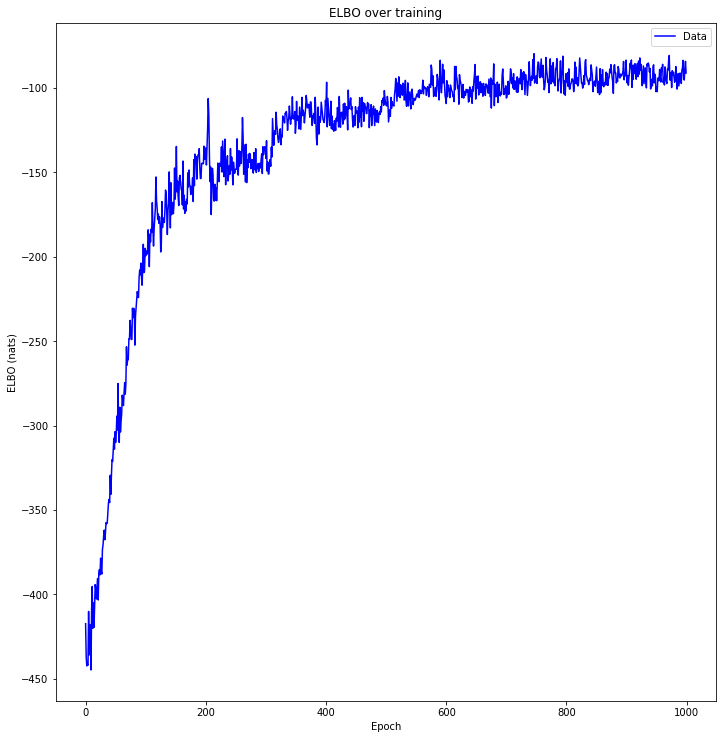

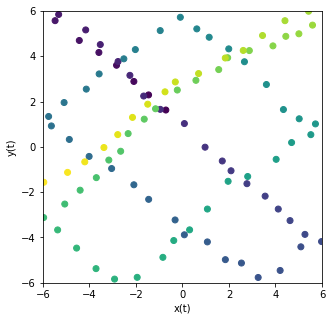

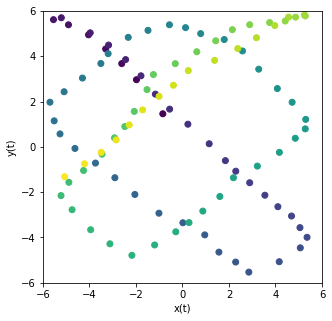

In [21]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=False,
        patience=100,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = mcmc.reduce_resample_move_smc(importance_sampler.folder.operator, lambda: range(T),
                                                            initializer=importance_sampler.folder._initializer, moves=5)
    (direction, position, uncertainty, noise), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [22]:
trained_params

"{'noise__loc': 'tensor([-1.6973, -1.7550], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-2.3350, -2.5134], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[-1.6900,  0.0000],\n        [ 0.0178, -1.7505]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([-0.8606,  1.4884], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-1.0329, -1.2860], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-2.2952, -2.3553], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[-0.6440,  0.6603],\n        [-0.7500,  0.6628],\n        [-0.7742,  0.6114],\n        [-0.8602,  0.5899],\n        [-1.0407,  0.7386],\n        [-1.1360,  0.4262],\n        [ 1.0733, -0.6299],\n        [ 0.7477, -0.6750],\n        [ 0.7222, -0.7086],\n        [ 0.5767, -0.6678],\n        [ 0.6304, -0.8442],\n        [ 0.7419, -0.6388],\n        [ 0.9349, -0.7048],\n        [ 0.9287, -0.8616],\n        [ 0.7135, -0.6322],\n        [ 0.5062, -0.5257],\n        [ 0.6407, -0.5527],\n

In [23]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])

Position at time 0 tensor([-0.7143,  1.6284])
Position at time 1 tensor([-1.4571,  2.2949])
Position at time 2 tensor([-2.0896,  2.8900])
Position at time 3 tensor([-2.8348,  3.6050])
Position at time 4 tensor([-3.5940,  4.1687])
Position at time 5 tensor([-4.4365,  4.6985])
Position at time 6 tensor([-5.4772,  5.5738])
Position at time 7 tensor([-5.3245,  5.8473])
Position at time 8 tensor([-4.1616,  5.1644])
Position at time 9 tensor([-3.5335,  4.5184])
Position at time 10 tensor([-2.7697,  3.7699])
Position at time 11 tensor([-2.2596,  3.1587])
Position at time 12 tensor([-1.6675,  2.2460])
Position at time 13 tensor([-0.9532,  1.6571])
Position at time 14 tensor([0.0837, 1.0305])
Position at time 15 tensor([ 0.9731, -0.0126])
Position at time 16 tensor([ 1.7129, -0.6219])
Position at time 17 tensor([ 2.0897, -1.0534])
Position at time 18 tensor([ 2.7738, -1.6239])
Position at time 19 tensor([ 3.5564, -2.1737])
Position at time 20 tensor([ 4.1210, -2.7440])
Position at time 21 tenso

In [24]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([-0.8440,  1.4625])
Inferred position at time 1 tensor([-1.9774,  2.9659])
Inferred position at time 2 tensor([-2.6111,  3.6775])
Inferred position at time 3 tensor([-3.3028,  4.3240])
Inferred position at time 4 tensor([-4.0402,  4.9483])
Inferred position at time 5 tensor([-4.9030,  5.3910])
Inferred position at time 6 tensor([-5.5477,  5.6180])
Inferred position at time 7 tensor([-5.2099,  5.7014])
Inferred position at time 8 tensor([-3.9678,  5.0361])
Inferred position at time 9 tensor([-3.1786,  4.4963])
Inferred position at time 10 tensor([-2.4446,  3.8545])
Inferred position at time 11 tensor([-1.7841,  3.1389])
Inferred position at time 12 tensor([-1.1642,  2.3291])
Inferred position at time 13 tensor([-0.5509,  1.6669])
Inferred position at time 14 tensor([0.2343, 1.0018])
Inferred position at time 15 tensor([1.1496, 0.1396])
Inferred position at time 16 tensor([ 1.8467, -0.6065])
Inferred position at time 17 tensor([ 2.2936, -1.0730])
Inferr

In [25]:
bouncing_ball_smc = importance.reduce_smc(importance_sampler.folder.operator, lambda: range(T), initializer=importance_sampler.folder._initializer)
(direction, position, uncertainty, noise), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [26]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([-0.8663,  1.5124])
Inferred position at time 1 tensor([-2.0145,  3.0032])
Inferred position at time 2 tensor([-2.5068,  3.6954])
Inferred position at time 3 tensor([-3.2435,  4.3324])
Inferred position at time 4 tensor([-4.0580,  5.0233])
Inferred position at time 5 tensor([-4.7773,  5.4240])
Inferred position at time 6 tensor([-5.4818,  5.6161])
Inferred position at time 7 tensor([-5.3674,  5.6876])
Inferred position at time 8 tensor([-4.4021,  5.0208])
Inferred position at time 9 tensor([-3.5532,  4.3090])
Inferred position at time 10 tensor([-2.7622,  3.7446])
Inferred position at time 11 tensor([-2.2045,  3.0641])
Inferred position at time 12 tensor([-1.1011,  2.2723])
Inferred position at time 13 tensor([-0.3037,  1.6694])
Inferred position at time 14 tensor([0.6011, 0.9400])
Inferred position at time 15 tensor([1.5798, 0.1194])
Inferred position at time 16 tensor([ 2.1780, -0.6099])
Inferred position at time 17 tensor([ 2.7148, -1.1855])
Inferr

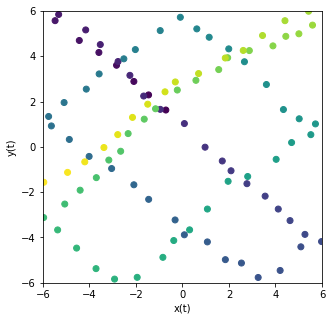

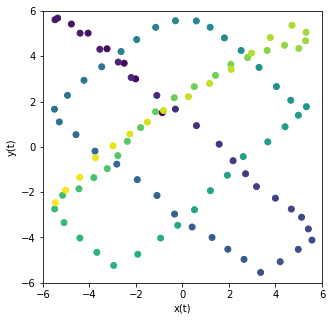

In [27]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)